In [5]:
import numpy as np
import torch as th

In [24]:
inputs = th.Tensor([[1,0,0],[0,1,0],[0,0,1]])
messages = th.Tensor([[0,0],[1,1],[2,2]])

batch_size = messages.size(0)

id_sampled_messages = np.arange(batch_size)
sampled_messages = messages[id_sampled_messages]
sampled_messages = sampled_messages.unsqueeze(0)
sampled_messages = sampled_messages.repeat(batch_size, 1, 1)
sampled_messages = sampled_messages.permute(1, 0, 2)
sampled_messages = sampled_messages.reshape([batch_size * batch_size, sampled_messages.size(-1)])
sampled_x = inputs.repeat(batch_size, 1, 1, 1)
sampled_x = sampled_x.reshape([batch_size * batch_size, *inputs.size()[1:]])

print(sampled_x)
print(sampled_messages)

eps=-10**10
log_probs = th.Tensor([0,0,eps,eps,0,eps,eps,eps,0])
#m1|x1, m2|x2, m3|x3, m2|x1, m2|x2, m2|x3, m3|x1, m3|x2, m3|x3

log_pi_m_x = log_probs.reshape([batch_size, batch_size]).T
pi_m_x = th.exp(log_pi_m_x)
p_x = th.ones(batch_size) / batch_size  # Here we set p(x)=1/batch_size
p_x = p_x.to(pi_m_x.device)  # Fix device issue

print(log_pi_m_x)
print("cc")
print(pi_m_x.sum(1))

log_p_x = th.log(p_x)
log_pi_m = th.log((pi_m_x * p_x).sum(1))
log_pi_m_x = th.log(pi_m_x.diagonal(0))

mutual_information = log_pi_m_x + log_p_x - log_pi_m

loss_mi = -1*log_pi_m_x*mutual_information.detach()

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [2., 2.],
        [2., 2.],
        [2., 2.]])
tensor([[ 0.0000e+00, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10,  0.0000e+00]])
cc
tensor([1., 2., 1.])


In [34]:
target_messages=[]

for sender_id in ["_","_"]:
    for _ in range(10):
        messages = th.Tensor([[2,2],[1,1]])
        target_messages.append(messages)

target_messages=th.stack(target_messages)

print(target_messages.size())

torch.Size([20, 2, 2])


In [52]:
import collections

C = collections.namedtuple("Batch",["data","sender_id","receiver_id","imitator_id"])

a=C(sender_id=2,receiver_id=3,imitator_id=4,data=2)

if getattr(a, "sender_id", False):
    print("coucou")

coucou


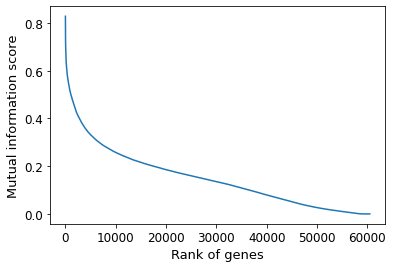

50


In [57]:
import matplotlib.pyplot as plt

mi_values=np.load("/Users/mrita/Desktop/Work/CUP/saved_mi_values.npy")
gene_labels=np.load("/Users/mrita/Desktop/Work/CUP/gene_labels.npy")

ordered_mi_idx = np.argsort(mi_values)[::-1]

plt.plot(mi_values[ordered_mi_idx])
plt.xlabel("Rank of genes",size=13)
plt.ylabel("Mutual information score",size=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

print(np.sum(mi_values>0.7))

In [114]:
voc_size=5

messages=th.Tensor([[2,3,4,5],[2,3,1,5]])
start_token = th.Tensor(messages.size(0)*[voc_size+1]).to(int)
start_token = start_token.unsqueeze(1)
messages = th.cat((start_token,messages),dim=1)

print(messages.size())
print(messages)

torch.Size([2, 5])
tensor([[6., 2., 3., 4., 5.],
        [6., 2., 3., 1., 5.]])


In [115]:
1e-3

0.001

# Language model

In [575]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TextGenerator(torch.nn.ModuleList):

    def __init__(self, batch_size,hidden_dim, max_len, vocab_size,window):
        super(TextGenerator, self).__init__()
    
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_size = vocab_size
        self.num_classes = vocab_size
        self.sequence_len = window
    
        # Dropout
        self.dropout = nn.Dropout(0.25)
    
        # Embedding layer
        self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
    
        # Bi-LSTM
        self.lstm_cell_forward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.lstm_cell_backward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.sender_norm_h_forward = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_h_backward = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_c_forward = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_c_backward = nn.LayerNorm(self.hidden_dim)
        
        # LSTM layer
        self.lstm_cell = nn.GRUCell(self.hidden_dim, self.hidden_dim)
        self.lstm_cell_2 = nn.GRUCell(self.hidden_dim, self.hidden_dim)
        self.sender_norm_h = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_c = nn.LayerNorm(self.hidden_dim)
    
        # Linear layer
        self.linear = nn.Linear(self.hidden_dim, self.num_classes)
        #self.linear = nn.Linear(self.sequence_len*self.hidden_dim, self.num_classes)
        
        
        
    def forward(self, x,length):
        

        # LSTM
        # hs = [batch_size x hidden_size]
        # cs = [batch_size x hidden_size]
        hs_forward = torch.zeros(x.size(0), self.hidden_dim)
        cs_forward = torch.zeros(x.size(0), self.hidden_dim)
        hs_backward = torch.zeros(x.size(0), self.hidden_dim)
        cs_backward = torch.zeros(x.size(0), self.hidden_dim)

        # LSTM
        # hs = [batch_size x (hidden_size * 2)]
        # cs = [batch_size x (hidden_size * 2)]
        hs_lstm = torch.zeros(x.size(0), self.hidden_dim)
        cs_lstm = torch.zeros(x.size(0), self.hidden_dim)

        # Weights initialization
        #torch.nn.init.kaiming_normal_(hs_forward)
        #torch.nn.init.kaiming_normal_(cs_forward)
        #torch.nn.init.kaiming_normal_(hs_backward)
        #torch.nn.init.kaiming_normal_(cs_backward)
        #torch.nn.init.kaiming_normal_(hs_lstm)
        #torch.nn.init.kaiming_normal_(cs_lstm)

        # From idx to embedding
        out = self.embedding(x)

        # Prepare the shape for LSTM Cells
        out = out.view(self.sequence_len, x.size(0), -1)

        forward = []
        backward = []
        
        """
        for i in range(self.sequence_len):
            hs_forward, cs_forward = self.lstm_cell_forward(out[i], (hs_forward, cs_forward))
            hs_forward = self.sender_norm_h_forward(hs_forward)
            cs_forward = self.sender_norm_c_forward(cs_forward)
            forward.append(hs_forward)

        # Backward
        for i in reversed(range(self.sequence_len)):
            hs_backward, cs_backward = self.lstm_cell_backward(out[i], (hs_backward, cs_backward))
            hs_backward = self.sender_norm_h_backward(hs_backward)
            cs_backward = self.sender_norm_c_backward(cs_backward)
            backward.append(hs_backward)

        # LSTM
        for fwd, bwd in zip(forward, backward):
            input_tensor = torch.cat((fwd, bwd), 1)
            hs_lstm, cs_lstm = self.lstm_cell(input_tensor, (hs_lstm, cs_lstm))
            hs_lstm = self.sender_norm_h(hs_lstm)
            cs_lstm = self.sender_norm_c(cs_lstm)
        """
        hss=[]
        css=[]
        
        for i in range(self.sequence_len):
            hs_lstm = self.lstm_cell(out[i], hs_lstm)
            
            #hs_lstm, cs_lstm = self.lstm_cell(out[i], (hs_lstm, cs_lstm))
            #hs_lstm=torch.nn.functional.normalize(hs_lstm)
            #cs_lstm=torch.nn.functional.normalize(cs_lstm)
            hs_lstm = self.sender_norm_h(hs_lstm)
            #cs_lstm = self.sender_norm_c(cs_lstm)
            hss.append(hs_lstm)
            #css.append(cs_lstm)
        
        #hs_lstm_2 = torch.zeros(x.size(0), self.hidden_dim)
        
        #for i in range(self.sequence_len):
        #    hs_lstm_2 = self.lstm_cell_2(hss[i], hs_lstm_2)
            
        
            
        length = nn.functional.one_hot(length-1,num_classes=self.sequence_len)
        #length=1-torch.cumsum(length,dim=1)
            
        hs_out=torch.stack(hss,dim=1)
        hs_out=length.unsqueeze(2).detach()*hs_out
        hs_out=hs_out.sum(dim=1)
        
        hs_out = self.dropout(hs_out)
        
        #cs_out=torch.stack(css,dim=1)
        #cs_out=length.unsqueeze(2)*cs_out
        #cs_out=cs_out.sum(dim=1)
        
        #hss=torch.stack(hss,dim=1)
        #hss=hss.resize(hss.size(0),hss.size(1)*hss.size(2))
            
        
        #length = nn.functional.one_hot(length,num_classes=self.sequence_len)
        #length=length.unsqueeze(2)
        #length=length.repeat(1,1,self.hidden_dim)
        #length=length.flatten(1)
        # Last hidden state is passed through a linear layer
        #hs_lstm=hs_lstm.repeat(1,self.sequence_len)
    
        #pre_out = hs_lstm * length
        pre_out=hs_out
        out = self.linear(pre_out)

        return out

In [472]:
1-torch.cumsum(torch.Tensor([[0,1,0,0],[0,0,1,0]]),dim=1)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.]])

In [573]:
def train(model,sequences,message_length,num_epochs,batch_size,hidden_dim,max_len,vocab_size,lr):
    
    
    #params=list(model.embedding.parameters())
    #params+=list(model.lstm_cell.parameters())
    #params+=list(model.sender_norm_h.parameters())
    #params+=list(model.sender_norm_c.parameters())
    
    # Optimizer initialization
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
    
    ce = nn.CrossEntropyLoss(reduce=False)
  
    # Defining number of batches
    num_batches = int(len(sequences) / batch_size)
  
    # Set model in training mode
    model.train()
  
    # Training pahse
    for epoch in range(1,num_epochs+1):
    
        # Mini batches
        for i in range(num_batches):
      
            # Batch definition
            try:
                x_batch = sequences[i * batch_size : (i + 1) * batch_size]
                y_batch = targets[i * batch_size : (i + 1) * batch_size]
                len_batch = message_length[i * batch_size : (i + 1) * batch_size]
            except:
                x_batch = sequences[i * batch_size :]
                y_batch = targets[i * batch_size :]
                len_batch = message_length[i * batch_size :]
        
        
            # Convert numpy array into torch tensors
            x = torch.from_numpy(x_batch).type(torch.LongTensor)
            y = torch.from_numpy(y_batch).type(torch.LongTensor)
            length = torch.from_numpy(len_batch).type(torch.LongTensor)
            
            # Feed the model
            y_pred = model(x,length)
            
            # Loss calculation
            loss = ce(y_pred,y.squeeze())
            
            #print(loss)
            
            #print(y_pred,y.squeeze())
            #print(loss)

            # Clean gradients
            optimizer.zero_grad()

            # Calculate gradientes
            loss.mean().backward()

            # Updated parameters
            optimizer.step()
      
        print("Epoch: %d ,  loss: %.5f " % (epoch, loss.mean().item()))
        
        #if epoch%100==0:
        #    scheduler.step()
        
        
def generator(model, sequences, n_chars,window):
  
    # Set the model in evalulation mode
    model.eval()
  
    # Define the softmax function
    softmax = nn.Softmax(dim=1)
  
    # Randomly is selected the index from the set of sequences
    #start = np.random.randint(0, len(sequences)-1)
    start=0
  
    # The pattern is defined given the random idx
    pattern = sequences[start]
  
    # By making use of the dictionaries, it is printed the pattern
    print("\nPattern: \n")
    print(''.join([str(value) for value in pattern]))
  
    # In full_prediction we will save the complete prediction
    full_prediction = pattern.copy()
  
    # The prediction starts, it is going to be predicted a given
    # number of characters
    for i in range(n_chars):
    
        # The numpy patterns is transformed into a tesor-type and reshaped
        new_pattern = torch.from_numpy(pattern).type(torch.LongTensor)
        new_pattern=new_pattern[-window:]
        new_pattern = new_pattern.view(1,-1)

        # Make a prediction given the pattern
        prediction = model(new_pattern)
        # It is applied the softmax function to the predicted tensor
        #prediction = softmax(prediction)
        prediction=torch.exp(prediction)
        print(prediction)

        # The prediction tensor is transformed into a numpy array
        prediction = prediction.squeeze().detach().numpy()
        # It is taken the idx with the highest probability
        arg_max = np.argmax(prediction)
        
        print(arg_max)
        
        # The current pattern tensor is transformed into numpy array
        #pattern = pattern.squeeze().detach().numpy()
        # The new pattern is composed by the "old" pattern + the predicted character
        pattern = np.append(pattern, arg_max)

    # The full prediction is saved
    #full_prediction = np.append(full_prediction, arg_max)
        
    print("Prediction: \n")
    print(''.join([str(value) for value in pattern]))
    
def get_prob(model, sequences, PAD=11, max_len=10):
    
    #sequences=np.array([[char] for char in sequences])
  
    # Set the model in evalulation mode
    model.eval()
  
    # Define the softmax function
    softmax = nn.Softmax(dim=1)
  
    # Randomly is selected the index from the set of sequences
    #start = np.random.randint(0, len(sequences)-1)
    start=0
  
    # The pattern is defined given the random idx
    pattern = [sequences[start]] + [PAD]*(max_len-1)
  
    # In full_prediction we will save the complete prediction
    full_prediction = pattern.copy()
    probs=[]

    # The prediction starts, it is going to be predicted a given
    # number of characters
    for i in range(1,len(sequences)):
        new_pattern=np.array([pattern])
        # The numpy patterns is transformed into a tesor-type and reshaped
        length = max_len-np.sum(new_pattern==11,axis=1)
        print(length)
        new_pattern = torch.from_numpy(new_pattern).type(torch.LongTensor)
        length = torch.from_numpy(np.array(length)).type(torch.LongTensor)
        new_pattern = new_pattern.view(1,-1)

        # Make a prediction given the pattern
        print(new_pattern)
        prediction = model(new_pattern,length)
        # It is applied the softmax function to the predicted tensor
        prediction = softmax(prediction)

        # The prediction tensor is transformed into a numpy array
        prediction = prediction.squeeze().detach().numpy()
        print(prediction,sequences[i])
        # It is taken the idx with the highest probability
        prob=prediction[sequences[i]]
        arg_max = sequences[i]
        
        # The current pattern tensor is transformed into numpy array
        #pattern = pattern.squeeze().detach().numpy()
        # The new pattern is composed by the "old" pattern + the predicted character
        pattern[i] = arg_max
        probs.append(prob)

    # The full prediction is saved
    #full_prediction = np.append(full_prediction, arg_max)
    print(np.prod(probs))

In [78]:
def build_sequences(text, max_len):
    x = list()
    y = list()
    PAD=11
    
    for seq in text:
        for i in range(1,len(seq)):
            s = seq[:i]+(max_len-i)*[PAD]
            x.append(np.array(s))
            y.append(np.array(seq[i]))
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y

#print(build_sequences(text,window))

In [579]:
text=[]

for i in range(1,1000):
    rd1=np.random.randint(2,4,1)[0]
    #rd2=np.random.randint(2,5,1)[0]
    rd2=rd1
    text.append([0,rd1,rd2,1])


lr=0.001
num_epochs = 1000
batch_size = 10
hidden_dim = 128
max_len = 4
vocab_size = 12

model = TextGenerator(batch_size=batch_size, 
                      hidden_dim=hidden_dim, 
                      max_len=max_len,
                      window=max_len,
                      vocab_size=vocab_size)

sequences, targets = build_sequences(text,max_len=max_len)
message_length = max_len-np.sum(sequences==11,axis=1)

train(model,sequences,message_length,num_epochs,batch_size,hidden_dim,max_len,vocab_size,lr)
#generator(model=model, sequences=np.array([[0]]), n_chars=9,window=window)


#for i in range(1,12):
#    test=[[0,i,1]]
#    get_prob(model,test)

Epoch: 1 ,  loss: 0.44582 
Epoch: 2 ,  loss: 0.43045 
Epoch: 3 ,  loss: 0.43562 
Epoch: 4 ,  loss: 0.45575 
Epoch: 5 ,  loss: 0.49655 
Epoch: 6 ,  loss: 0.46698 
Epoch: 7 ,  loss: 0.45782 
Epoch: 8 ,  loss: 0.46847 
Epoch: 9 ,  loss: 0.46058 
Epoch: 10 ,  loss: 0.45644 
Epoch: 11 ,  loss: 0.45464 
Epoch: 12 ,  loss: 0.43160 
Epoch: 13 ,  loss: 0.43911 
Epoch: 14 ,  loss: 0.44923 
Epoch: 15 ,  loss: 0.45256 
Epoch: 16 ,  loss: 0.46263 
Epoch: 17 ,  loss: 0.45824 
Epoch: 18 ,  loss: 0.46024 
Epoch: 19 ,  loss: 0.44063 
Epoch: 20 ,  loss: 0.45722 
Epoch: 21 ,  loss: 0.45249 
Epoch: 22 ,  loss: 0.48525 
Epoch: 23 ,  loss: 0.46851 
Epoch: 24 ,  loss: 0.49997 
Epoch: 25 ,  loss: 0.46314 
Epoch: 26 ,  loss: 0.44967 
Epoch: 27 ,  loss: 0.46229 
Epoch: 28 ,  loss: 0.45545 
Epoch: 29 ,  loss: 0.47182 


KeyboardInterrupt: 

In [ ]:
1/6*(np.log(2)+np.log(2))

In [580]:
for i in range(2,4):
    j=i
    print(i)
    test=[0,i,j,1]
    get_prob(model,test,max_len=4)
        
#print("Others")
#test=[0,1,2,1,1,1]
#get_prob(model,test)
#test=[0,2,1,1,1,1]
#get_prob(model,test)

2
[1]
tensor([[ 0, 11, 11, 11]])
[3.8784510e-08 5.8387400e-07 4.7987333e-01 5.2012569e-01 4.0020321e-08
 3.4352915e-08 3.7311793e-08 5.9340387e-08 3.0514514e-08 3.8158024e-08
 3.6475978e-08 3.9666187e-08] 2
[2]
tensor([[ 0,  2, 11, 11]])
[3.4308095e-11 3.1778409e-09 5.4009807e-01 4.5990190e-01 4.7046353e-11
 4.3385712e-11 4.1363499e-11 6.1503434e-11 4.0545817e-11 4.4846241e-11
 3.3379698e-11 4.3330142e-11] 2
[3]
tensor([[ 0,  2,  2, 11]])
[1.07474765e-10 5.54179778e-08 5.44645905e-01 4.55354065e-01
 1.32995143e-10 1.22945279e-10 1.16088743e-10 1.64411068e-10
 1.16262909e-10 1.20910906e-10 8.95479524e-11 1.12130576e-10] 1
1.4363158e-08
3
[1]
tensor([[ 0, 11, 11, 11]])
[3.8784510e-08 5.8387400e-07 4.7987333e-01 5.2012569e-01 4.0020321e-08
 3.4352915e-08 3.7311793e-08 5.9340387e-08 3.0514514e-08 3.8158024e-08
 3.6475978e-08 3.9666187e-08] 3
[2]
tensor([[ 0,  3, 11, 11]])
[1.1417826e-08 8.5740581e-08 5.0513369e-01 4.9486622e-01 1.1350623e-08
 9.8442268e-09 1.1332019e-08 1.2481494e-08 9.190

In [458]:
for i in range(1,1000):
    rd1=np.random.randint(2,4,1)[0]
    #rd2=np.random.randint(2,5,1)[0]
    rd2=rd1
    print([0,rd1,rd2,1])

[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]

In [365]:
for i in range(1,1000):
    rd1=np.random.randint(0,5,1)[0]
    print(rd1)

4
4
2
3
2
4
4
2
3
4
2
3
3
4
4
4
3
3
2
2
2
4
3
4
4
4
2
4
4
3
2
2
3
4
4
4
3
3
4
3
4
4
3
3
4
4
3
3
4
2
4
2
2
3
2
3
4
4
3
4
4
3
3
3
2
2
2
3
3
3
4
3
3
4
4
2
3
3
4
2
3
4
4
4
2
4
2
2
4
3
3
3
3
4
4
2
2
3
3
4
2
4
4
2
2
4
4
4
2
2
4
2
2
3
2
2
2
2
4
4
3
3
2
4
3
4
2
2
4
2
4
3
2
3
4
2
2
2
4
2
4
4
4
4
4
3
4
2
3
2
4
2
3
3
4
3
2
3
2
2
4
3
2
2
3
4
3
3
2
3
3
4
2
2
4
4
3
2
2
4
2
2
4
2
4
2
3
3
2
4
3
4
3
4
3
3
3
4
3
2
4
4
2
3
3
2
2
2
3
2
4
3
4
4
2
2
2
2
4
4
4
3
3
2
4
3
2
2
4
3
3
4
3
3
3
2
4
4
4
4
2
3
4
4
2
4
3
2
3
4
3
4
2
3
3
4
4
3
2
4
2
3
2
4
4
4
3
2
4
3
3
3
3
2
4
3
4
3
4
2
3
2
2
2
3
4
2
3
2
4
4
3
2
2
2
2
2
2
2
3
2
3
2
2
2
2
2
3
4
3
2
3
3
4
2
3
3
2
3
3
2
4
3
4
4
3
2
2
2
2
3
3
3
2
3
4
4
3
2
2
2
2
3
4
3
2
4
2
2
4
3
3
4
2
4
2
4
2
2
2
4
3
3
3
2
3
2
2
4
4
3
2
3
4
3
3
2
2
4
2
3
4
4
4
4
2
2
2
3
4
4
2
3
3
3
2
2
3
3
4
3
4
3
3
4
2
2
4
2
4
3
4
3
2
4
3
4
2
4
3
3
2
4
2
2
2
3
2
2
2
2
2
4
4
3
2
2
2
4
3
2
2
4
2
4
2
4
3
3
3
3
2
2
4
2
2
3
4
3
4
3
3
4
3
3
2
2
3
4
4
3
3
4
2
2
2
2
4
4
4
4
3
3
2
3
2
3
2
4
2
3
2
2
4
2
3
3
3
4
2


In [215]:
message=th.zeros(20,10,10)
voc_size=10

start_token = th.Tensor(messages.size(0) * [voc_size]).to(int).to(messages.device)
start_token = start_token.unsqueeze(1)

print(start_token)

tensor([[10],
        [10]])


In [2]:
# CUP
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


cancer_types = {'Bladder': 0,
                 'Brain': 1,
                 'Breast': 2,
                 'Cervix': 3,
                 'Colon': 4,
                 'CorpusUteri': 5,
                 'HeadandNeck': 6,
                 'Hematopoietic': 7,
                 'Kidney': 8,
                 'Liver': 9,
                 'Lung': 10,
                 'LymphNodes': 11,
                 'Ovary': 12,
                 'Pancreas': 13,
                 'Prostate': 14,
                 'Skyn': 15,
                 'Stomach': 16,
                 'ThyroidGland': 18}

In [907]:
nb_geness=[]
accuracies=[]
f1_scores=[]
precisions=[]
recalls=[]

for nb_genes in range(10,2950,20):

    cancer_labels = np.load("/Users/mrita/Desktop/Work/CUP/cancer_labels_val.npy")
    cancer_labels = [cancer_types[cancer] for cancer in cancer_labels]
    preds = np.load("/Users/mrita/Desktop/Work/CUP/y_pred/nb_genes_{}.npy".format(nb_genes))

    accuracy = np.sum(cancer_labels==preds)/len(preds)
    f1score=f1_score(cancer_labels,preds,average=None)
    precision, recall, _, _ = precision_recall_fscore_support(cancer_labels,preds)
    
    
    nb_geness.append(nb_genes)
    accuracies.append(accuracy)
    f1_scores.append(np.mean(f1score))
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))
    
for nb_genes in range(3000,5000,50):

    cancer_labels = np.load("/Users/mrita/Desktop/Work/CUP/cancer_labels_val.npy")
    cancer_labels = [cancer_types[cancer] for cancer in cancer_labels]
    preds = np.load("/Users/mrita/Desktop/Work/CUP/y_pred/nb_genes_{}.npy".format(nb_genes))

    accuracy = np.sum(cancer_labels==preds)/len(preds)
    f1score=f1_score(cancer_labels,preds,average=None)
    precision, recall, _, _ = precision_recall_fscore_support(cancer_labels,preds)
    
    nb_geness.append(nb_genes)
    accuracies.append(accuracy)
    f1_scores.append(np.mean(f1score))
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))

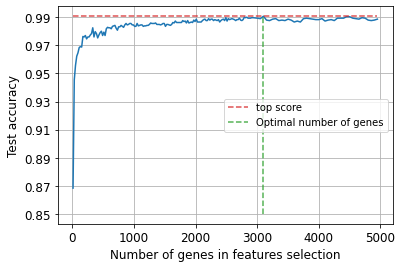

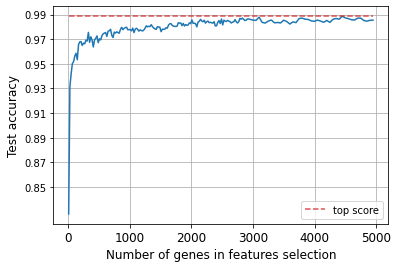

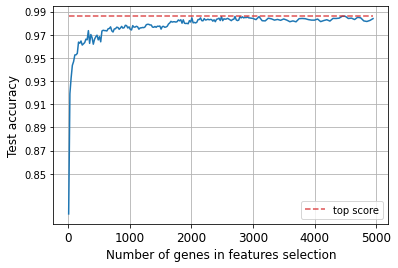

In [908]:
plt.plot(nb_geness,accuracies)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(accuracies),np.max(accuracies)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.plot([nb_geness[np.argmax(accuracies)],nb_geness[np.argmax(accuracies)]],[0.85,np.max(accuracies)],
         c="tab:green",
         linestyle="--",
        alpha=0.8,
        label="Optimal number of genes")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=12)
plt.legend()
plt.show()

plt.plot(nb_geness,precisions)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(precisions),np.max(precisions)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=10)
plt.legend()
plt.show()

plt.plot(nb_geness,recalls)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(recalls),np.max(recalls)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=10)
plt.legend()
plt.show()

In [1077]:
import torch.nn as nn

class BieberLSTM(nn.Module):
    
    def __init__(self, nb_layers, nb_lstm_units=100, embedding_dim=3, batch_size=2,vocab_size=5):
        
        super(BieberLSTM, self).__init__()
        
        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.nb_vocab_words = vocab_size
        self.padding_idx = 0
        
        self.word_embedding = nn.Embedding(
            num_embeddings=self.nb_vocab_words,
            embedding_dim=self.embedding_dim,
            padding_idx=self.padding_idx
        )
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True,
        )
        
        self.hidden_to_symbol = nn.Linear(self.nb_lstm_units, self.nb_vocab_words)

        # build actual NN
        #self.__build_model()

    def __build_model(self):
        # build embedding layer first
        

        # whenever the embedding sees the padding index it'll make the whole vector zeros
        self.word_embedding = nn.Embedding(
            num_embeddings=self.nb_vocab_words,
            embedding_dim=self.embedding_dim,
            padding_idx=self.padding_idx
        )

        # design LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
        )

        # output layer which projects back to tag space
        self.hidden_to_tag = nn.Linear(self.nb_lstm_units, self.nb_tags)

    def init_hidden(self,batch_size):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(1,batch_size, self.nb_lstm_units)*0.
        hidden_b = torch.randn(1,batch_size, self.nb_lstm_units)*0.
        return (hidden_a, hidden_b)
    
    
    def forward(self, X, X_lengths):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        
        batch_size, seq_len = X.size()
        
        hidden = self.init_hidden(batch_size)

        # ---------------------
        # 1. embed the input
        # Dim transformation: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)
        X = self.word_embedding(X)
    

        # ---------------------
        # 2. Run through RNN
        # TRICK 2 ********************************
        # Dim transformation: (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, nb_lstm_units)
        
        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True)

        # now run through LSTM
        X, self.hidden = self.lstm(X, hidden)

        # undo the packing operation
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        print(X.size())

        # ---------------------
        # 3. Project to tag space
        # Dim transformation: (batch_size, seq_len, nb_lstm_units) -> (batch_size * seq_len, nb_lstm_units)

        # this one is a bit tricky as well. First we need to reshape the data so it goes into the linear layer
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.hidden_to_symbol(X)

        # ---------------------
        # 4. Create softmax activations bc we're doing classification
        # Dim transformation: (batch_size * seq_len, nb_lstm_units) -> (batch_size, seq_len, nb_tags)
        X = F.log_softmax(X, dim=1)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, seq_len, self.nb_vocab_words)

        Y_hat = X
        return Y_hat
    
    
    def loss(self, Y_hat, Y, X_lengths):
        # TRICK 3 ********************************
        # before we calculate the negative log likelihood, we need to mask out the activations
        # this means we don't want to take into account padded items in the output vector
        # simplest way to think about this is to flatten ALL sequences into a REALLY long sequence
        # and calculate the loss on that.
        
        # create a mask by filtering out all tokens that ARE NOT the padding token
        mask = nn.functional.one_hot(X_lengths,num_classes=Y_hat.size(1)+1)
        mask= 1-torch.cumsum(mask,dim=1)[:,:-1]
        # flatten all the labels
        print(Y.size())
        Y = Y.view(-1)
        print(Y.size())

        # flatten all predictions
        Y_hat = Y_hat.view(-1, self.nb_vocab_words)
        
        
        # count how many tokens we have
        nb_tokens = int(torch.sum(mask).item())


        # pick the values for the label and zero out the rest with the mask
        Y_hat = Y_hat[range(Y_hat.size(0)), Y] * mask.view(-1)

        # compute cross entropy loss which ignores all <PAD> tokens
        ce_loss = -torch.sum(Y_hat) / nb_tokens

        return ce_loss

NameError: name 'mask' is not defined

In [963]:
def build_dataset(sequences,padding_idx=0,max_len=4):
    
    X=[]
    y=[]
    X_length=[]
    
    for seq in sequences:
        X.append(seq[:-1]+[padding_idx]*(max_len-1-len(seq[:-1])))
        y.append(seq[1:]+[padding_idx]*(max_len-1-len(seq[1:])))
        X_length.append(len(seq)-1)
        
    X=np.array(X)
    y=np.array(y)
    X_length=np.array(X_length)
        
    X=torch.Tensor(X).to(int)
    y=torch.Tensor(y).to(int)
    X_length=torch.Tensor(X_length).to(int)
    
    return X,y,X_length

build_dataset(sequences,max_len=6)

(tensor([[1, 7, 2, 7, 2],
         [1, 7, 7, 0, 0],
         [1, 4, 5, 7, 2],
         ...,
         [1, 6, 3, 2, 2],
         [1, 7, 2, 5, 2],
         [1, 4, 7, 8, 2]]),
 tensor([[ 7,  2,  7,  2,  2],
         [ 7,  7, 10,  0,  0],
         [ 4,  5,  7,  2,  2],
         ...,
         [ 6,  3,  2,  2,  2],
         [ 7,  2,  5,  2,  2],
         [ 4,  7,  8,  2,  2]]),
 tensor([5, 3, 5,  ..., 5, 5, 5]))

In [1078]:
PAD_TOKEN = 0
START_TOKEN = 1
EOS_TOKEN = 2

sequences=[]

for i in range(5000):
    rd1=np.random.randint(1,10,1)[0]
    rd2=np.random.randint(1,10,1)[0]
    rd3=np.random.randint(1,10,1)[0]
    sequences.append([rd1,rd2,rd3,2,2])

for j in range(1000):
    sequences.append([7,7,0,0,0])
    
np.random.shuffle(sequences)

max_len=np.max([len(seq) for seq in sequences])
batch_size=128
vocab_size=10

X,y,X_lengths = build_data_lm(th.Tensor(sequences))

model = BieberLSTM(nb_layers=1,
                   nb_lstm_units=100, 
                   embedding_dim=10, 
                   batch_size=batch_size,
                   vocab_size=vocab_size+2)


tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        ...,
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])
tensor([[ 1.,  7., 10.,  3.,  4.,  4.],
        [ 1.,  4.,  4., 11.,  4.,  4.],
        [ 1., 10.,  6.,  8.,  4.,  4.],
        ...,
        [ 1.,  6.,  9.,  5.,  4.,  4.],
        [ 1., 10.,  3.,  8.,  4.,  4.],
        [ 1., 11.,  7.,  6.,  4.,  4.]])


In [1079]:
lr=0.001
num_epochs=400

optimizer = optim.RMSprop(model.parameters(), lr=lr)

model.train()

num_batches = int(X.size(0) / batch_size)
  
# Training pahse
for epoch in range(1,num_epochs+1):

    # Mini batches
    for i in range(num_batches):

        x_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        len_batch = X_lengths[i * batch_size : (i + 1) * batch_size]
        
        idx_sorted=torch.argsort(len_batch,descending=True)  
        x_batch=x_batch[idx_sorted]
        y_batch=y_batch[idx_sorted]
        len_batch=len_batch[idx_sorted]
    
        Y_hat = model(x_batch,len_batch)
        loss = model.loss(Y_hat=Y_hat, Y=y_batch, X_lengths=len_batch)

        optimizer.zero_grad()

        # Calculate gradientes
        loss.backward()

        # Updated parameters
        optimizer.step()
    
    print("Epoch {} : loss={}".format(epoch,loss.detach().item()))

torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])

torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
Epoch 3 : loss=1.2382601499557495
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Siz

torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torc

KeyboardInterrupt: 

In [1058]:
def get_prob(model,X_test,X_lengths_test,y_test,nb_vocab_words,batch_size,seq_len):
    
    model.eval()

    Y_hat = model(X_test,X_lengths_test)
    mask = nn.functional.one_hot(X_lengths_test,num_classes=seq_len+1)
    mask= 1-torch.cumsum(mask,dim=1)[:,:-1]
    
    Y_hat = Y_hat*mask.unsqueeze(2)
    Y_hat = torch.exp(Y_hat)
    Y_hat = Y_hat.view(-1, nb_vocab_words)

    Y = y_test.view(-1)
    Y_hat=Y_hat[range(Y_hat.size(0)),Y]
    Y_hat=Y_hat.resize(batch_size,seq_len)

    return Y_hat.prod(1)

sequences_test=[]

sequences_test.append([7,7,0,0,0])

for i in range(5000):
    rd1=np.random.randint(1,10,1)[0]
    rd2=np.random.randint(1,10,1)[0]
    rd3=np.random.randint(1,10,1)[0]
    sequences_test.append([rd1,rd2,rd3,2,2])

    
max_len_test=np.max([len(seq) for seq in sequences_test])

X_test,y_test,X_lengths_test = build_data_lm(th.Tensor(sequences_test))

idx_sorted=torch.argsort(X_lengths_test,descending=True)  
idx_sorted_inv = torch.empty_like(idx_sorted)
idx_sorted_inv[idx_sorted] = torch.arange(idx_sorted.size(0), device=idx_sorted.device)
X_test=X_test[idx_sorted]
y_test=y_test[idx_sorted]
X_lengths_test=X_lengths_test[idx_sorted]

vocab_size=12

probs=get_prob(model,X_test,X_lengths_test,y_test,nb_vocab_words=vocab_size,batch_size=X_test.size(0),seq_len=X_test.size(1))

X_test=X_test[idx_sorted_inv]
y_test=y_test[idx_sorted_inv]
X_lengths_test=X_lengths_test[idx_sorted_inv]
probs=probs[idx_sorted_inv]

print(X_test[2])
print(probs[2].mean())
    

tensor([ 1,  4, 11,  7,  4])
tensor(0.0008, grad_fn=<MeanBackward0>)


In [996]:
PAD_TOKEN=0
START_TOKEN=1
EOS_TOKEN=2

def build_data_lm(messages, max_len):
    x = []
    y = []
    x_length = []

    messages = EOS_TOKEN + torch.Tensor(messages)
    messages=torch.cat((torch.Tensor([START_TOKEN]*messages.size(0)).unsqueeze(1),messages),dim=1)

    eos_mask = messages == EOS_TOKEN
    x_lengths = max_len+1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
    x_lengths.add_(1).clamp_(max=max_len+1)

    pad_mask=1-torch.cumsum(1*eos_mask,dim=1)
    messages = messages * pad_mask
    messages += EOS_TOKEN* eos_mask
    
    x=messages[:,:-1]
    y=messages[:,1:]
    x_lengths=message_lengths-1
    

    return x, y, x_length


max_len=10

messages=torch.Tensor([[1,2,3,0,4,3,5,2,9,9],
                      [8,8,8,8,8,0,8,8,8,8],
                      [1,2,3,4,4,3,0,2,9,9]])

build_data_lm(messages,max_len)

(tensor([[ 1.,  3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.],
         [ 1., 10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.],
         [ 1.,  3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.]]),
 tensor([[ 3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
         [10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.,  0.],
         [ 3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.,  0.]]),
 [])

In [947]:
EOS_TOKEN=2
max_len=10

messages=torch.Tensor([[1,2,3,0,4,3,5,2,9,9],
                      [8,8,8,8,8,0,8,8,8,8],
                      [1,2,3,4,4,3,0,2,9,9]])

messages = EOS_TOKEN+messages
messages=torch.cat((torch.Tensor([START_TOKEN]*messages.size(0)).unsqueeze(1),messages),dim=1)

eos_mask = messages == EOS_TOKEN
message_lengths = max_len+1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
message_lengths.add_(1).clamp_(max=max_len+1)

pad_mask=1-torch.cumsum(1*eos_mask,dim=1)
messages = messages * pad_mask
messages += 2* eos_mask

x=messages[:,:-1]
y=messages[:,1:]
x_lengths=message_lengths-1

print(x)
print(y)
print(x_lengths)

tensor([[ 1.,  3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 1., 10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.]])
tensor([[ 3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.,  0.],
        [ 3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.,  0.]])
tensor([4, 6, 7])


In [1073]:
PAD_TOKEN = 0
START_TOKEN = 1
EOS_TOKEN = 2

import torch as th
messages=torch.Tensor([[1,2,3,0,4,3,5,2,9,9],
                      [8,8,8,8,8,0,8,8,8,8],
                      [1,2,3,4,4,3,0,2,9,9],
                      [1,2,3,4,4,3,8,2,9,9],
                      [0, 0, 8, 8, 8, 5, 5, 7, 6, 0]]).to(float)

def build_data_lm(messages):

    max_len = messages.size(1)

    messages = EOS_TOKEN + messages
    start_tokens = th.Tensor([START_TOKEN] * messages.size(0)).unsqueeze(1).to(messages.device)
    messages = th.cat((start_tokens, messages), dim=1)

    eos_mask = messages == EOS_TOKEN
    message_lengths = max_len + 1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
    message_lengths.add_(1).clamp_(max=max_len)
    
    pad_mask = 1 - th.cumsum(1 * eos_mask, dim=1).clamp_(max=1)
    messages = messages * pad_mask
    messages += EOS_TOKEN * eos_mask
    
    messages.to(int)

    x = messages[:, :-1].to(int)
    y = messages[:, 1:].to(int)
    x_lengths = (message_lengths).to(int)

    return x, y, x_lengths

build_data_lm(messages)

tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 1.,  3.,  4.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., 10., 10., 10., 10., 10.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  5.,  6.,  6.,  5.,  0.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  5.,  6.,  6.,  5., 10.,  4., 11., 11.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64)


(tensor([[ 1,  3,  4,  5,  2,  0,  0,  0,  0,  0],
         [ 1, 10, 10, 10, 10, 10,  2,  0,  0,  0],
         [ 1,  3,  4,  5,  6,  6,  5,  2,  0,  0],
         [ 1,  3,  4,  5,  6,  6,  5, 10,  4, 11],
         [ 1,  2,  2,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[ 3,  4,  5,  2,  0,  0,  0,  0,  0,  0],
         [10, 10, 10, 10, 10,  2,  0,  0,  0,  0],
         [ 3,  4,  5,  6,  6,  5,  2,  0,  0,  0],
         [ 3,  4,  5,  6,  6,  5, 10,  4, 11, 11],
         [ 2,  2,  0,  0,  0,  0,  0,  0,  0,  2]]),
 tensor([ 5,  7,  8, 10,  2]))

In [1062]:
def build_dataset(sequences,padding_idx=0,max_len=4):
    
    X=[]
    y=[]
    X_length=[]
    
    for seq in sequences:
        X.append(seq[:-1]+[padding_idx]*(max_len-1-len(seq[:-1])))
        y.append(seq[1:]+[padding_idx]*(max_len-1-len(seq[1:])))
        X_length.append(len(seq)-1)
        
    X=np.array(X)
    y=np.array(y)
    X_length=np.array(X_length)
        
    X=torch.Tensor(X).to(int)
    y=torch.Tensor(y).to(int)
    X_length=torch.Tensor(X_length).to(int)
    
    return X,y,X_length

messages=[[1,2,3,0],
          [8,8,8,8,8,0],
          [1,2,3,4,4,3,0],
          [1,2,3,4,4,3,8,2,9,9]]

build_dataset(messages,max_len=10)

(tensor([[1, 2, 3, 0, 0, 0, 0, 0, 0],
         [8, 8, 8, 8, 8, 0, 0, 0, 0],
         [1, 2, 3, 4, 4, 3, 0, 0, 0],
         [1, 2, 3, 4, 4, 3, 8, 2, 9]]),
 tensor([[2, 3, 0, 0, 0, 0, 0, 0, 0],
         [8, 8, 8, 8, 0, 0, 0, 0, 0],
         [2, 3, 4, 4, 3, 0, 0, 0, 0],
         [2, 3, 4, 4, 3, 8, 2, 9, 9]]),
 tensor([3, 5, 6, 9]))

In [1116]:
cell_types = {'rnn': nn.RNNCell, 'gru': nn.GRUCell, 'LSTM': nn.LSTM}
PAD_TOKEN = 0
START_TOKEN = 1
EOS_TOKEN = 2


def build_data_lm(messages):

    max_len = messages.size(1)

    messages = EOS_TOKEN + messages
    start_tokens = th.Tensor([START_TOKEN] * messages.size(0)).unsqueeze(1).to(messages.device)
    messages = th.cat((start_tokens, messages), dim=1)

    eos_mask = messages == EOS_TOKEN
    message_lengths = max_len + 1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
    message_lengths.add_(1).clamp_(max=max_len)

    pad_mask = 1 - th.cumsum(1 * eos_mask, dim=1).clamp_(max=1)
    messages = messages * pad_mask
    messages += EOS_TOKEN * eos_mask
    messages = messages.to(int)

    x = messages[:, :-1]
    y = messages[:, 1:]
    x_lengths = message_lengths - 1

    return x, y, x_lengths


class LanguageModel():

    def __init__(self,
                 model,
                 optimizer,
                 batch_size):

        self.model = model
        self.optimizer = optimizer
        self.batch_size = batch_size

    def get_prob_messages(self, messages):

        # Gerer le pb descending order pour les lengths

        self.model.eval()

        with th.no_grad():
            x_test, y_test, x_lengths_test = build_data_lm(messages=messages)
            
            print(x_test[-10:],x_lengths_test[-10:])
            print(y_test[-10:])

            # Reorder by length
            y_hat = self.model(x_test, x_lengths_test)
            
            print(y_hat[-10:])

            batch_size, seq_len, nb_vocab_words = y_hat.size()
            mask = nn.functional.one_hot(x_lengths_test, num_classes=seq_len + 1)
            mask = 1 - th.cumsum(mask, dim=1)[:, :-1]

            y_hat = y_hat * mask.unsqueeze(2)
            y_hat = th.exp(y_hat)
            y_hat = y_hat.contiguous()
            y_hat = y_hat.view(-1, self.model.voc_size)

            y_test = y_test.contiguous()
            y_hat = y_hat[range(y_hat.size(0)), y_test.view(-1)]
            y_hat = y_hat.resize(batch_size, seq_len)
            
            print(y_hat[-10:])

        return y_hat.prod(1)

    def compute_loss(self, y_hat, y, x_lengths):

        # create a mask by filtering out all tokens that ARE NOT the padding token
        mask = F.one_hot(x_lengths, num_classes=y_hat.size(1) + 1)
        mask = 1 - th.cumsum(mask, dim=1)[:, :-1]
        mask = mask.to(y_hat.device)

        # flatten all the labels
        y = y.contiguous()
        y = y.view(-1)

        # flatten all predictions
        y_hat = y_hat.contiguous()
        y_hat = y_hat.view(-1, self.model.voc_size)

        # count how many tokens we have
        nb_tokens = int(th.sum(mask).item())

        # pick the values for the label and zero out the rest with the mask
        y_hat = y_hat[range(y_hat.size(0)), y] * mask.view(-1)

        # compute cross entropy loss which ignores all <PAD> tokens
        ce_loss = -th.sum(y_hat) / nb_tokens

        return ce_loss

    def train(self,
              messages,
              n_epochs: int = 200,
              threshold: float = 1e-2):

        x, y, x_lengths = build_data_lm(messages=messages)
        
        r=torch.randperm(x.size(0))
        x=x[r]
        y=y[r]
        x_lengths=x_lengths[r]

        self.model.train()

        num_batches = int(x.size(0) / self.batch_size)

        prev_losses = []

        continue_training = True
        epoch = 0

        while continue_training:

            mean_loss=0.

            # Mini batches
            for i in range(num_batches):
                x_batch = x[i * self.batch_size: (i + 1) * self.batch_size]
                y_batch = y[i * self.batch_size: (i + 1) * self.batch_size]
                len_batch = x_lengths[i * self.batch_size: (i + 1) * self.batch_size]

                y_hat = self.model(x_batch, len_batch)
                loss = self.compute_loss(y_hat, y_batch, len_batch)

                self.optimizer.zero_grad()

                # Calculate gradients
                loss.backward()

                # Updated parameters
                self.optimizer.step()

                mean_loss+=loss.item()

            mean_loss/=num_batches
            
            print(mean_loss,abs(mean_loss - np.mean(prev_losses)))

            if (len(prev_losses) > 4 and abs(mean_loss - np.mean(prev_losses)) < threshold) or epoch >= n_epochs:
                continue_training = False
            else:
                prev_losses.append(mean_loss)
                epoch += 1
                if len(prev_losses) > 5 : prev_losses.pop(0)


class LanguageModelNetwork(nn.Module):

    def __init__(self,
                 max_len: int,
                 voc_size: int,
                 num_layers: int = 1,
                 hidden_size: int = 128,
                 embedding_size: int = 20,
                 device : str ="cpu") -> None:
        super(LanguageModelNetwork, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.voc_size = voc_size
        self.max_len = max_len
        self.device=device

        self.word_embedding = nn.Embedding(
            num_embeddings=self.voc_size,
            embedding_dim=self.embedding_size,
            padding_idx=PAD_TOKEN
        )

        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.hidden_to_symbol = nn.Linear(self.hidden_size, self.voc_size)

    def init_hidden(self, batch_size):
        hidden_a = th.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        hidden_b = th.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        return hidden_a, hidden_b

    def forward(self, x, x_lengths):
        batch_size = x.size(0)

        # Prepare data
        hidden = self.init_hidden(batch_size)
        x = self.word_embedding(x)

        x = th.nn.utils.rnn.pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # now run through LSTM
        x, hidden = self.lstm(x, hidden)

        # undo the packing operation
        x, _ = th.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        if x.size(1) < self.max_len:
            dummy_tensor = th.zeros((batch_size,self.max_len - x.size(1), x.size(2)),device=self.device)
            x = th.cat([x, dummy_tensor], 1)

        x = x.contiguous()
        x = x.view(-1, x.size(2))

        # Pass through actual linear layer
        y_hat = self.hidden_to_symbol(x)
        y_hat = F.log_softmax(y_hat, dim=1)
        y_hat = y_hat.view(batch_size, self.max_len, self.voc_size)

        return y_hat


def get_language_model(lm_params:dict,game_params:dict,device:str):

    model = LanguageModelNetwork(max_len=game_params["channel"]["max_len"],
                                 voc_size=game_params["channel"]["voc_size"]+2,
                                 num_layers=lm_params["num_layers"],
                                 hidden_size=lm_params["hidden_size"],
                                 embedding_size=lm_params["embedding_size"],
                                 device=device)

    model.to(device)

    optimizer = th.optim.RMSprop(model.parameters(), lr=0.001)

    language_model = LanguageModel(model=model,optimizer=optimizer,batch_size=lm_params["batch_size"])

    return language_model

In [1117]:
LM=get_language_model({"batch_size":128,"num_layers":1,"hidden_size":128,"embedding_size":40},{"channel":{"max_len":5,"voc_size":5}},device="cpu")

sequences=[]

for i in range(5000):
    rd1=np.random.randint(1,4,1)[0]
    rd2=np.random.randint(1,4,1)[0]
    rd3=np.random.randint(1,4,1)[0]
    rd4=np.random.randint(1,4,1)[0]
    sequences.append([rd1,rd2,rd3,rd4,2])

for j in range(1000):
    sequences.append([4,4,0,0,0])
    
messages=th.Tensor(sequences)

LM.train(messages,threshold=1e-4)

1.1557879447937012 nan
1.0798795845197595 0.07590836027394166
1.077527087667714 0.040306676989016355
1.0766051541204038 0.02779305153998779
1.0761058641516643 0.021344078623730445
1.0757886896962705 0.01739243735437812
1.0755648276080256 0.001616448423136907
1.0753940006960994 0.0009243239527161329
1.0752565212871716 0.0006351859673210392
1.0751422825066939 0.00047969818115234375
1.0750439581663713 0.0003853061924810053
1.074955429719842 0.0003248883330302377
1.0748750567436218 0.0002833817316136855
1.074804046879644 0.00025060280509592303
1.0747401273768882 0.00022402742634652917
1.0746815878411997 0.0002021359360735442
1.0746273657549983 0.00018388395724100448
1.0745774870333464 0.00016814988592406266
1.0745317884113477 0.00015433456586766425
1.074488657972087 0.00014301331146926444
1.0744468025539233 0.0001345748486727416
1.0744041670923647 0.0001302532527758249
1.074359030827232 0.0001307497853817452
1.0743153069330298 0.0001307824383609546
1.07427128760711 0.00013150546861728785
1

In [1118]:
LM.get_prob_messages(messages)[-2]

tensor([[1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2]]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
tensor([[6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2]])
tensor([[[-1.6887e+01, -1.6989e+01, -1.7292e+01, -1.2289e+00, -1.3083e+00,
          -1.2757e+00, -1.8460e+00],
         [-1.9589e+01, -2.0113e+01, -1.6168e+01, -1.4851e+01, -1.4629e+01,
          -1.5075e+01, -1.1921e-06],
         [-1.7242e+01, -1.7313e+01, -1.1921e-07, -2.3737e+01, -2.3813e+01,
          -2.3906e+01, -1.6952e+01],
         [-2.0021e+00, -1.9691e+00, -2.0072e+00, -1.8853e+00, -1.9187e+00,
          -1.9788e+00, -1.8696e+00],
         [-

tensor(0.1579)

In [1148]:
agent_names = ["Speaker_1","Listener_1","Listener_2"]

population_probs = th.zeros((3,3))
population_probs[0,1]=1
population_probs[0,2]=1

population_probs /= population_probs.sum()

population_probs = population_probs.flatten()

print(population_probs.size())

print(population_probs)

sampled_pair_id = th.multinomial(population_probs, 1)

grid_names=[(agent_names[i], agent_names[j]) for i in range(len(agent_names)) for j in range(len(agent_names))]

sender_id=grid_names[sampled_pair_id][0]

receiver_ids=[name[1] for j,name in enumerate(grid_names) if name[0]==sender_id and population_probs[j]>0]

print(receiver_ids)

torch.Size([9])
tensor([0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
['Listener_1', 'Listener2']


In [37]:
import numpy as np
import torch as th

batch_size=1024
n_pairs=100
n_attributes=5
max_len=10

inputs = np.random.randint(0,50,size=(batch_size,n_attributes))
messages = np.random.randint(0,10,size=(batch_size,max_len))
messages_len = 10*np.ones((batch_size),dtype=int)

idx=np.random.randint(0,batch_size,n_pairs*2)

inputs_pairs = inputs[idx].reshape((n_pairs,2,-1))
messages_pairs = inputs[idx].reshape((n_pairs,2,-1))
messages_len_pairs = messages_len[idx].reshape((n_pairs,2))

In [38]:
import editdistance
from scipy.stats import spearmanr

def compute_language_similarity(messages_1 : th.Tensor,
                                messages_2 : th.Tensor,
                                len_messages_1 : th.Tensor = None,
                                len_messages_2 : th.Tensor = None) -> th.Tensor:

    distances = []
    for i in range(len(messages_1)):
        m_1 = messages_1[i]
        m_2 = messages_2[i]
        len_m_1 = len_messages_1[i]
        len_m_2 = len_messages_2[i]
        distances.append(editdistance.eval(m_1[:len_m_1],m_2[:len_m_2])/max(len_m_1,len_m_2))

    similarity = 1 - th.Tensor(distances)

    return similarity

distances_inputs=np.mean(1-1*((inputs_pairs[:,0,:]-inputs_pairs[:,1,:])==0),axis=1)
distances_messages = 1 - compute_language_similarity(messages_1=messages_pairs[:, 0, :],
                                                                         messages_2=messages_pairs[:, 1, :],
                                                                         len_messages_1=messages_len_pairs[:, 0],
                                                                         len_messages_2=messages_len_pairs[:, 1])

top_sim = spearmanr(distances_inputs, distances_messages).correlation

In [41]:
type(messages_pairs)==np.ndarray

True